This example will show you how to couple proxy CRM and fractional flow model itself by Liang (2007) and Sayarpour (2009).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import numpy as np
from model import fractionalFlow

import lmfit

np.set_printoptions(threshold=np.inf)

Assuming we have exported the previously fitted data to excel format...

In [2]:
url = "https://raw.githubusercontent.com/frank1010111/pywaterflood/master/testing/data/"

prod = pd.read_csv(url + "production.csv", header=None)
predicted_prod = pd.read_csv(url + "prediction_primary_per-pair.csv", header=None).values # We used the already-predicted liquid production rate.
inj = pd.read_csv(url + "injection.csv", header=None).values
time = pd.read_csv(url + "time.csv", header=None).values[:,0]
f_ij_obs = pd.read_csv(url + "gains.csv", header=None).values


temp = np.random.uniform(low=0.024, high=0.7543, size=(time.shape[0],prod.shape[1]))
# pywaterflood has no oil data (AFAIK), so... we create one.
oil_prod = prod * -np.sort(-temp)

oil_prod=oil_prod.values

In [3]:
print(prod.shape)
print(predicted_prod.shape)
print(inj.shape)
print(time.shape)
print(f_ij_obs.shape)

(298, 4)
(298, 4)
(298, 5)
(298,)
(4, 5)


Finally, we can go to the fractional flow model.

In [4]:
# Initialize the class
fracflow = fractionalFlow.fracFlow_CRMP(liquid=predicted_prod, f_ij=f_ij_obs, inj=inj, oil=oil_prod, time=time)

### Starting the solver. We use leastsq here as the default.
### Feel free to change the method with other methods shown in lmfit documentations.
solve = fracflow.solver()
res = solve[3]
pred_oil_prod = abs(solve[0])

In [5]:
print(lmfit.fit_report(res))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 730
    # data points      = 1192
    # variables        = 8
    chi-square         = 9644311.03
    reduced chi-square = 8145.53296
    Akaike info crit   = 10742.2012
    Bayesian info crit = 10782.8683
[[Variables]]
    alpha_1:  0.13082918 +/- 0.24263329 (185.46%) (init = 2e-18)
    beta_1:   7.8250e-06 +/- 0.12784307 (1633770.34%) (init = 1.5)
    alpha_2:  0.17718901 +/- 0.29291174 (165.31%) (init = 2e-18)
    beta_2:   0.03709926 +/- 0.17501314 (471.74%) (init = 1.5)
    alpha_3:  0.03007523 +/- 0.06544381 (217.60%) (init = 2e-18)
    beta_3:   0.29530321 +/- 0.23268947 (78.80%) (init = 1.5)
    alpha_4:  0.01071095 +/- 0.03227505 (301.33%) (init = 2e-18)
    beta_4:   0.50116944 +/- 0.32159374 (64.17%) (init = 1.5)
[[Correlations]] (unreported correlations are < 0.100)
    C(alpha_3, beta_3) = -0.9999
    C(alpha_1, beta_1) = -0.9999
    C(alpha_2, beta_2) = -0.9998
    C(alpha_4, beta_4) = -0.9998


In [6]:
print('alpha coefficient results:\n')
print(solve[1])

alpha coefficient results:

[0.13082918 0.17718901 0.03007523 0.01071095]


In [7]:
print('beta coefficient results:\n')
print(solve[2])

beta coefficient results:

[7.82503304e-06 3.70992560e-02 2.95303214e-01 5.01169445e-01]


Showing the plots!

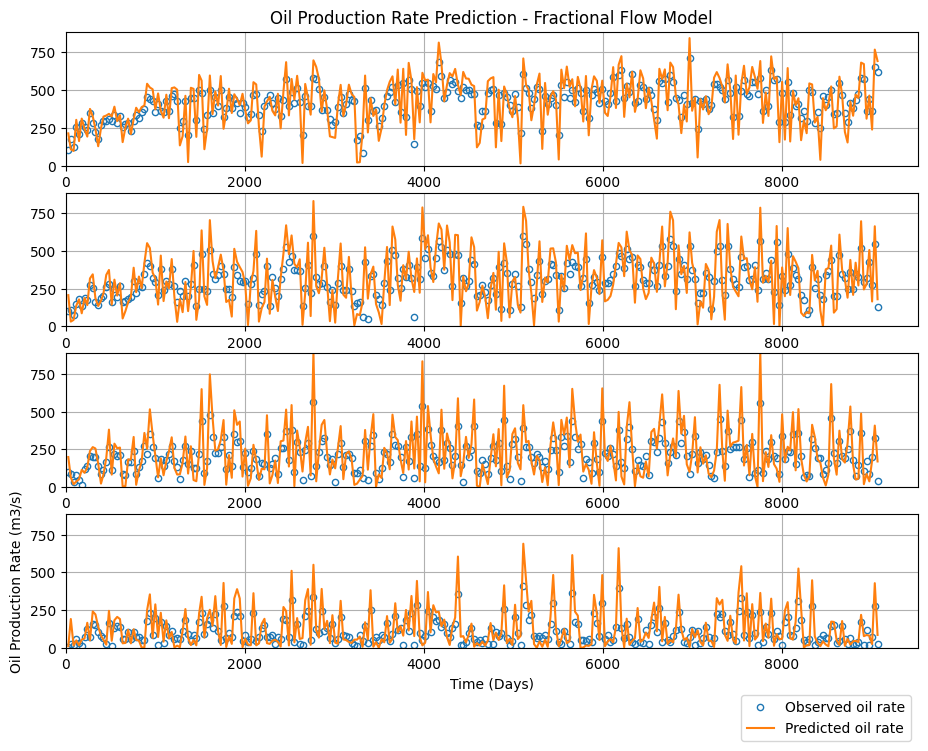

In [8]:
import scienceplots

fig, ax = plt.subplots(oil_prod.shape[1], figsize=(11,8), sharey=True)

for i in range(oil_prod.shape[1]):
  ax[i].plot(time, oil_prod[:,i], label=f'Observed oil rate', marker='o', markerfacecolor='None', markersize=4.5, ls='None')
  ax[i].plot(time, pred_oil_prod[:,i], label=f'Predicted oil rate')

  ax[i].set(xlim=(0,None), ylim=(0,None))
  ax[i].annotate(f'Producer {i+1}', xy=(100,1200), bbox=dict(boxstyle='round', pad=0.3, edgecolor='black', facecolor='white'))
  ax[i].grid(visible=True, which='both')

ax[i].set(xlabel='Time (Days)', ylabel='Oil Production Rate (m3/s)')
ax[0].set(title='Oil Production Rate Prediction - Fractional Flow Model')

legend = ax[i].legend(bbox_to_anchor=(1,-0.3), frameon=True)

In [9]:
# Checks error
err = (np.sum(oil_prod) - np.sum(pred_oil_prod))/np.sum(oil_prod) * 100
print(err)

-5.168857694932594


# Another Case: Bloto Alto & Baixo

### let's first start by importing our data

In [22]:
url = "https://github.com/leleony/proxy_crm/raw/master/data/"
fij_url = "https://github.com/leleony/proxy_crm/raw/master/data/results/"

prod_xls = pd.ExcelFile(url + "UNISIM_PROD.xlsx")
prod_bloto_alto = pd.read_excel(prod_xls, 'BlotoAlto', header=None).values
prod_bloto_baixo = pd.read_excel(prod_xls, 'BlotoBaixo', header=None).values

oil_xls = pd.ExcelFile(url + "UNISIM_OIL.xlsx")
oil_bloto_alto = pd.read_excel(oil_xls, 'BlotoAlto', header=None).values
oil_bloto_baixo = pd.read_excel(oil_xls, 'BlotoBaixo', header=None).values

inj_xls = pd.ExcelFile(url + "UNISIM_INJ.xlsx")
inj_bloto_alto = pd.read_excel(inj_xls, 'BlotoAlto', header=None).values
inj_bloto_baixo = pd.read_excel(inj_xls, 'BlotoBaixo', header=None).values

bhp_xls = pd.ExcelFile(url + "UNISIM_BHP.xlsx")
bhp_bloto_alto = pd.read_excel(bhp_xls, 'BlotoAlto', header=None).values
bhp_bloto_baixo = pd.read_excel(bhp_xls, 'BlotoBaixo', header=None).values

fij_bloto_alto = pd.read_excel(fij_url + "bloto_alto_lambda_ip.xlsx").drop(columns='Injector').values
fij_bloto_baixo = pd.read_excel(fij_url + "bloto_baixo_lambda_ip.xlsx").drop(columns='Injector').values

time = pd.read_excel(url + "UNISIM_TIME.xlsx", header= None).values[:,0]

## For Bloto Alto

In [23]:
print(prod_bloto_alto.shape)
print(fij_bloto_alto.shape)
print(inj_bloto_alto.shape)
print(oil_bloto_alto.shape)
print(time.shape)

(362, 11)
(9, 11)
(362, 9)
(362, 11)
(362,)


In [43]:
# Initialize the class
fracflow = fractionalFlow.fracFlow_CRMP(liquid=prod_bloto_alto, f_ij=fij_bloto_alto.T, inj=inj_bloto_alto, oil=oil_bloto_alto, time=time)

### Starting the solver. We use leastsq here as the default.
### Feel free to change the method with other methods shown in lmfit documentations.
solve = fracflow.solver(method='leastsq')
res = solve[3]
pred_oil_prod = abs(solve[0])

In [44]:
print(lmfit.fit_report(res))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 1119
    # data points      = 3982
    # variables        = 22
    chi-square         = 4.6680e+08
    reduced chi-square = 117879.296
    Akaike info crit   = 46521.4114
    Bayesian info crit = 46659.7812
##  Warning: uncertainties could not be estimated:
    alpha_11:  at initial value
    alpha_11:  at boundary
[[Variables]]
    alpha_1:   0.06422683 (init = 2e-18)
    beta_1:    0.10136688 (init = 1.5)
    alpha_2:   0.02240322 (init = 2e-18)
    beta_2:    0.21842339 (init = 1.5)
    alpha_3:   0.04275441 (init = 2e-18)
    beta_3:    0.13346655 (init = 1.5)
    alpha_4:   0.14108522 (init = 2e-18)
    beta_4:    0.09219412 (init = 1.5)
    alpha_5:   0.05606342 (init = 2e-18)
    beta_5:    0.03270169 (init = 1.5)
    alpha_6:   0.02662621 (init = 2e-18)
    beta_6:    0.19425037 (init = 1.5)
    alpha_7:   0.02976257 (init = 2e-18)
    beta_7:    8.0400e-08 (init = 1.5)
    alpha_8:   0.05113200 (init 

In [45]:
print('alpha coefficient results:\n')
print(solve[1])

alpha coefficient results:

[6.42268323e-02 2.24032152e-02 4.27544102e-02 1.41085220e-01
 5.60634203e-02 2.66262076e-02 2.97625726e-02 5.11320023e-02
 3.01735212e-02 1.99011368e-02 4.10182999e-12]


In [46]:
print('beta coefficient results:\n')
print(solve[2])

beta coefficient results:

[1.01366885e-01 2.18423390e-01 1.33466553e-01 9.21941234e-02
 3.27016860e-02 1.94250367e-01 8.03995270e-08 1.01888654e-01
 1.84966004e-01 2.70226628e-01 2.55035479e+00]


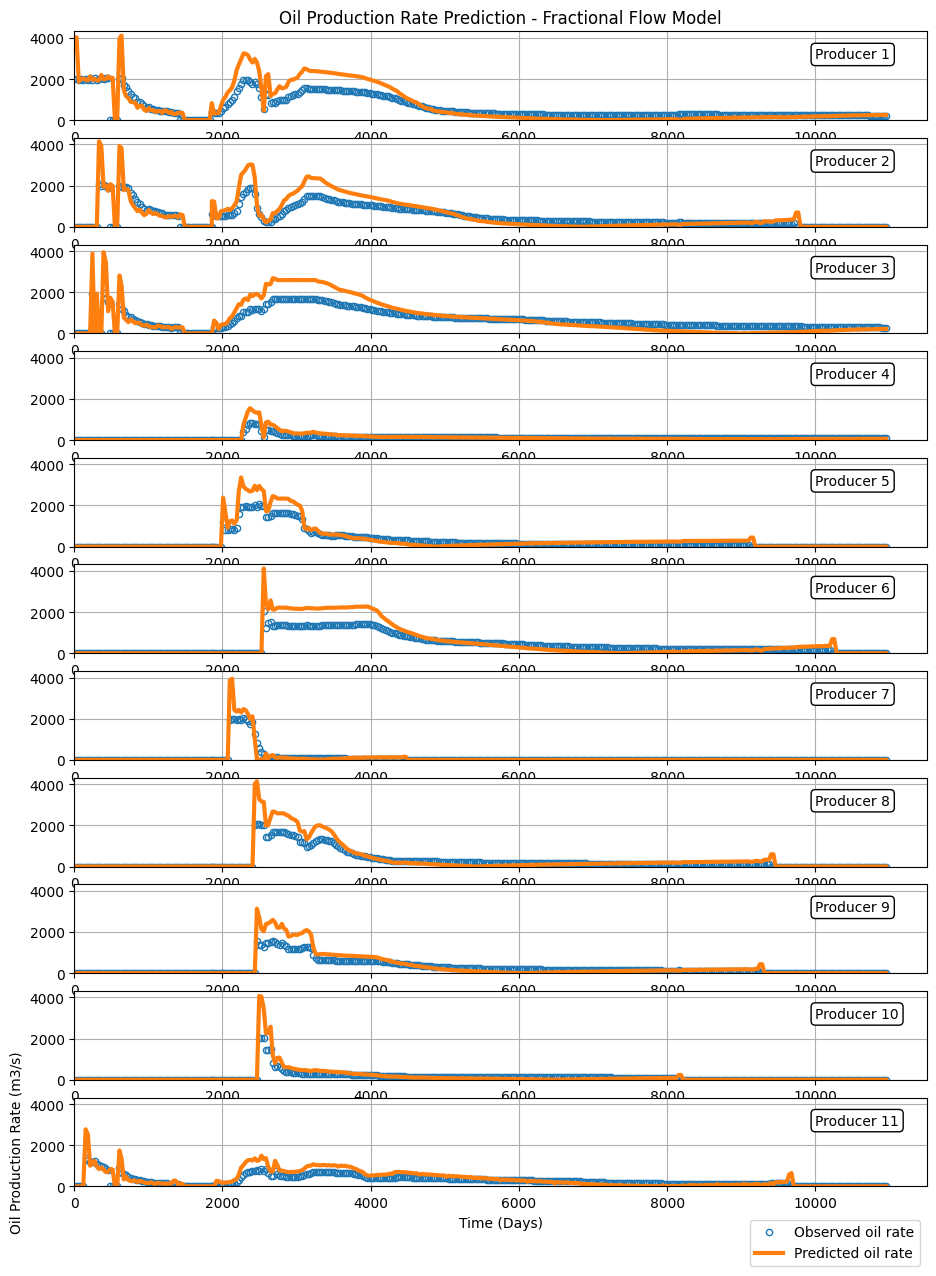

In [47]:
import scienceplots

fig, ax = plt.subplots(oil_bloto_alto.shape[1], figsize=(11,15), sharey=True)

for i in range(oil_bloto_alto.shape[1]):
  ax[i].plot(time, oil_bloto_alto[:,i], label=f'Observed oil rate', marker='o', markerfacecolor='None', markersize=4.5, ls='None')
  ax[i].plot(time, pred_oil_prod[:,i], label=f'Predicted oil rate', linewidth=3)

  ax[i].set(xlim=(0,None), ylim=(0,None))
  ax[i].annotate(f'Producer {i+1}', xy=(10000,3000), bbox=dict(boxstyle='round', pad=0.3, edgecolor='black', facecolor='white'))
  ax[i].grid(visible=True, which='both')

ax[i].set(xlabel='Time (Days)', ylabel='Oil Production Rate (m3/s)')
ax[0].set(title='Oil Production Rate Prediction - Fractional Flow Model')

legend = ax[i].legend(bbox_to_anchor=(1,-0.3), frameon=True)

In [31]:
# Checks error
err = (np.sum(oil_bloto_alto) - np.sum(pred_oil_prod))/np.sum(oil_bloto_alto) * 100
print(err)

-20.57223670790628


## For Bloto Baixo

In [49]:
# Initialize the class
fracflow = fractionalFlow.fracFlow_CRMP(liquid=prod_bloto_baixo, f_ij=fij_bloto_baixo.T, inj=inj_bloto_baixo, oil=oil_bloto_baixo, time=time)

### Starting the solver. We use leastsq here as the default.
### Feel free to change the method with other methods shown in lmfit documentations.
solve = fracflow.solver(method='leastsq')
res = solve[3]
pred_oil_prod = abs(solve[0])

In [50]:
print(lmfit.fit_report(res))

[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 14000
    # data points      = 1086
    # variables        = 6
    chi-square         = 90475316.7
    reduced chi-square = 83773.4414
    Akaike info crit   = 12316.7396
    Bayesian info crit = 12346.6811
##  Warning: uncertainties could not be estimated:
[[Variables]]
    alpha_1:  0.57567010 (init = 2e-18)
    beta_1:   0.08134803 (init = 1.5)
    alpha_2:  0.57843388 (init = 2e-18)
    beta_2:   1.1609e-08 (init = 1.5)
    alpha_3:  2.8614e-06 (init = 2e-18)
    beta_3:   1.39370643 (init = 1.5)


In [51]:
print('alpha coefficient results:\n')
print(solve[1])

alpha coefficient results:

[5.75670105e-01 5.78433878e-01 2.86135293e-06]


In [52]:
print('beta coefficient results:\n')
print(solve[2])

beta coefficient results:

[8.13480310e-02 1.16088816e-08 1.39370643e+00]


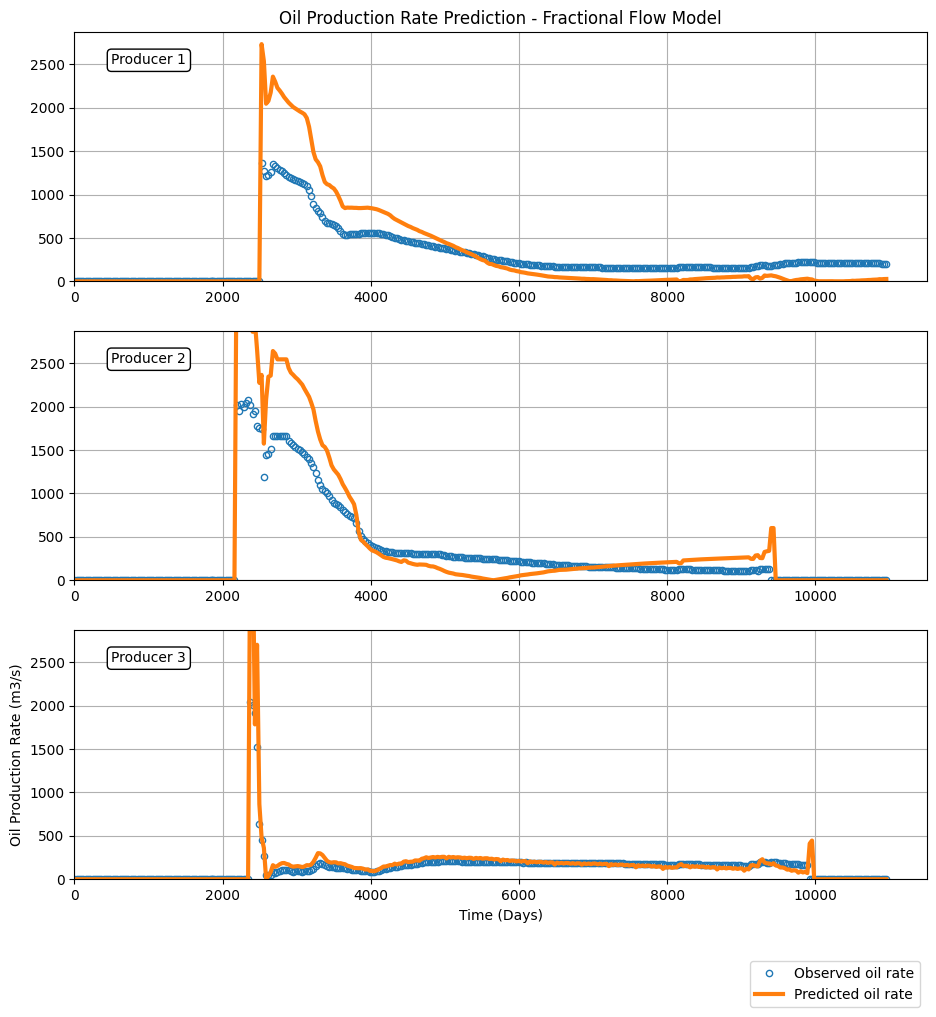

In [53]:
import scienceplots

fig, ax = plt.subplots(oil_bloto_baixo.shape[1], figsize=(11,11), sharey=True)

for i in range(oil_bloto_baixo.shape[1]):
  ax[i].plot(time, oil_bloto_baixo[:,i], label=f'Observed oil rate', marker='o', markerfacecolor='None', markersize=4.5, ls='None')
  ax[i].plot(time, pred_oil_prod[:,i], label=f'Predicted oil rate', linewidth=3)

  ax[i].set(xlim=(0,None), ylim=(0,None))
  ax[i].annotate(f'Producer {i+1}', xy=(500,2500), bbox=dict(boxstyle='round', pad=0.3, edgecolor='black', facecolor='white'))
  ax[i].grid(visible=True, which='both')

ax[i].set(xlabel='Time (Days)', ylabel='Oil Production Rate (m3/s)')
ax[0].set(title='Oil Production Rate Prediction - Fractional Flow Model')

legend = ax[i].legend(bbox_to_anchor=(1,-0.3), frameon=True)

In [54]:
# Checks error
err = (np.sum(oil_bloto_baixo) - np.sum(pred_oil_prod))/np.sum(oil_bloto_baixo) * 100
print(err)

-20.409918880913107
